# Assignment 2
# Waseem Raja Shaik
# 8894805

**Assignment 2 CSCN8000 Artificial Intelligence Algorithms and Mathematics**

Download heart disease dataset heart.csv in Resources folder and do following,  https://www.kaggle.com/fedesoriano/heart-failure-prediction

1. Consider the heart disease dataset in pandas dataframe
2. Remove outliers using mean,median,Z score. 
3. Convert text columns to numbers using label encoding and one hot encoding
4. Apply scaling
5. Build a machine learning classification model using support vector machine. 
  Demonstrate the standalone model as well as Bagging model and include observations about the performance
6. Now use decision tree classifier. Use standalone model as well as Bagging and check if you notice any difference in performance
7. Comparing performance of svm and decision tree classifier figure out where it makes most sense to use bagging and why. 
  
**Notes: This lab should be submitted as a notebook and an HTML. Follow https://docs.github.com/en/pages/quickstart.**
         

### Load the heart disease dataset into a pandas dataframe

In [36]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt

heart = pd.read_csv("../../practical_labs/heart.csv")
heart.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


### Checking null values

In [37]:
heart.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

### Summary

In [38]:
heart.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


### Remove outliers using mean, median, and Z-score


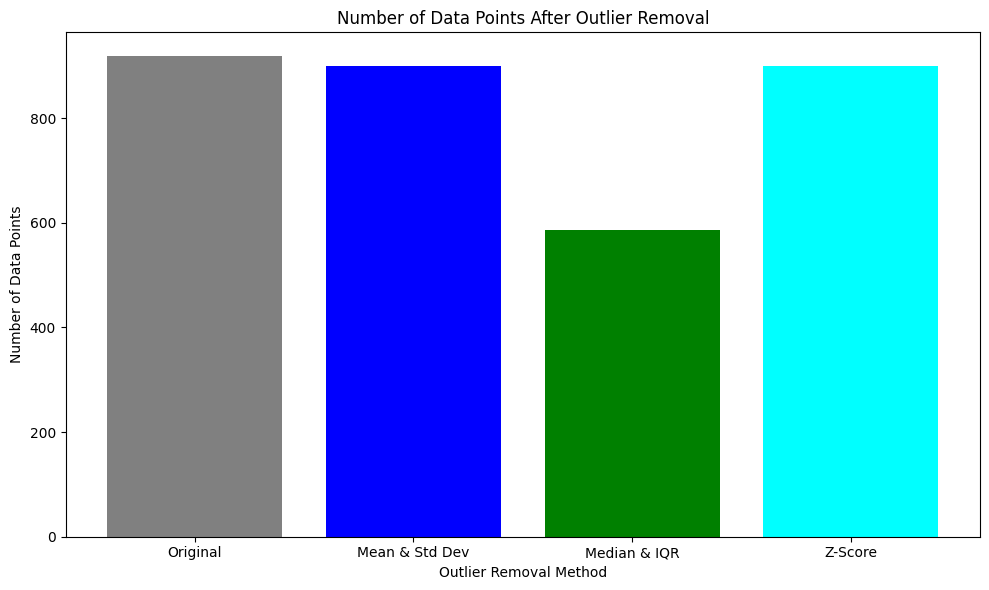

In [48]:
# Method 1: Using Mean and Standard Deviation
heart_df_mean_std = heart.copy()
for column in heart_df_mean_std.select_dtypes(include=[np.number]).columns:
    mean = heart_df_mean_std[column].mean()
    std = heart_df_mean_std[column].std()
    heart_df_mean_std = heart_df_mean_std[(heart_df_mean_std[column] >= mean - 3*std) & (heart_df_mean_std[column] <= mean + 3*std)]

# Method 2: Using Median and IQR
heart_df_iqr = heart.copy()
for column in heart_df_iqr.select_dtypes(include=[np.number]).columns:
    Q1 = heart_df_iqr[column].quantile(0.25)
    Q3 = heart_df_iqr[column].quantile(0.75)
    IQR = Q3 - Q1
    heart_df_iqr = heart_df_iqr[(heart_df_iqr[column] >= Q1 - 1.5*IQR) & (heart_df_iqr[column] <= Q3 + 1.5*IQR)]

# Method 3: Using Z-Score
heart_df_zscore = heart.copy()
z_scores = np.abs(zscore(heart_df_zscore.select_dtypes(include=[np.number])))
heart_df_zscore = heart_df_zscore[(z_scores < 3).all(axis=1)]

methods = ['Original', 'Mean & Std Dev', 'Median & IQR', 'Z-Score']
row_counts = [
    heart.shape[0],
    heart_df_mean_std.shape[0],
    heart_df_iqr.shape[0],
    heart_df_zscore.shape[0]
]

# Plotting the results
plt.figure(figsize=(10, 6))
plt.bar(methods, row_counts, color=['gray', 'blue', 'green', 'cyan'])
plt.title('Number of Data Points After Outlier Removal')
plt.ylabel('Number of Data Points')
plt.xlabel('Outlier Removal Method')
plt.tight_layout()
plt.show()


- Original: The dataset's original size before any outlier removal.
- Mean & Std Dev: Data points retained after removing outliers based on mean and standard deviation.
- Median & IQR: Data points retained after removing outliers using the median and interquartile range (IQR).
- Z-Score: Data points retained after removing outliers based on Z-scores.

From the graph, we can observe:

- The "Mean & Std Dev" and "Z-Score" methods retain almost the same number of data points, indicating they have similar effectiveness.
- The "Median & IQR" method is the most aggressive, removing the highest number of outliers.


***For the subsequent steps, I will use the dataset obtained from the Z-score method.***

In [49]:
heart = heart_df_zscore

### Convert text columns to numbers using label encoding and one hot encoding

In [50]:
categorical_columns = heart.select_dtypes(include=['object']).columns
unique_values = {column: heart[column].unique() for column in categorical_columns}

unique_values

{'Sex': array(['M', 'F'], dtype=object),
 'ChestPainType': array(['ATA', 'NAP', 'ASY', 'TA'], dtype=object),
 'RestingECG': array(['Normal', 'ST', 'LVH'], dtype=object),
 'ExerciseAngina': array(['N', 'Y'], dtype=object),
 'ST_Slope': array(['Up', 'Flat', 'Down'], dtype=object)}

For columns with only two unique values (like 'Sex' and 'ExerciseAngina'), we can use label encoding. For columns with more than two unique values, we'll use one hot encoding.

In [51]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
heart['Sex'] = le.fit_transform(heart['Sex'])
heart['ExerciseAngina'] = le.fit_transform(heart['ExerciseAngina'])
heart = pd.get_dummies(heart, columns=['ChestPainType', 'RestingECG', 'ST_Slope'], drop_first=True)
heart.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ST_Slope_Flat,ST_Slope_Up
0,40,1,140,289,0,172,0,0.0,0,True,False,False,True,False,False,True
1,49,0,160,180,0,156,0,1.0,1,False,True,False,True,False,True,False
2,37,1,130,283,0,98,0,0.0,0,True,False,False,False,True,False,True
3,48,0,138,214,0,108,1,1.5,1,False,False,False,True,False,True,False
4,54,1,150,195,0,122,0,0.0,0,False,True,False,True,False,False,True


### Apply Scaling

In [52]:
from sklearn.preprocessing import StandardScaler

X = heart.drop("HeartDisease", axis=1)
y = heart["HeartDisease"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled_df.head()


,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ST_Slope_Flat,ST_Slope_Up
0,-1.428154,0.515943,0.465900,0.849636,-0.550362,1.384320,-0.822945,-0.855469,2.063325,-0.534905,-0.22955,0.809702,-0.489898,-0.998888,1.134695
1,-0.475855,-1.938199,1.634714,-0.168122,-0.550362,0.752973,-0.822945,0.137516,-0.484655,1.869492,-0.22955,0.809702,-0.489898,1.001113,-0.881294
2,-1.745588,0.515943,-0.118507,0.793612,-0.550362,-1.535661,-0.822945,-0.855469,2.063325,-0.534905,-0.22955,-1.235023,2.041241,-0.998888,1.134695
3,-0.581666,-1.938199,0.349019,0.149344,-0.550362,-1.141069,1.215148,0.634008,-0.484655,-0.534905,-0.22955,0.809702,-0.489898,1.001113,-0.881294
4,0.053200,0.515943,1.050307,-0.028064,-0.550362,-0.588640,-0.822945,-0.855469,-0.484655,1.869492,-0.22955,0.809702,-0.489898,-0.998888,1.134695


### Build a machine learning classification model using support vector machine.

In [53]:
from sklearn.model_selection import train_test_split

# Splitting the data into training and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

X_train.shape, X_test.shape

((629, 15), (270, 15))

In [56]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

svm_model = SVC().fit(X_train, y_train)

svm_predictions = svm_model.predict(X_test)

svm_accuracy = accuracy_score(y_test, svm_predictions)
svm_classification_report = classification_report(y_test, svm_predictions)

print('SVM accuracy:',svm_accuracy)
print('SVM Classification')
print(svm_classification_report)

SVM accuracy: 0.8481481481481481
SVM Classification
              precision    recall  f1-score   support

           0       0.87      0.77      0.82       119
           1       0.84      0.91      0.87       151

    accuracy                           0.85       270
   macro avg       0.85      0.84      0.84       270
weighted avg       0.85      0.85      0.85       270



### Demonstrate the standalone model as well as Bagging model and include observations about the performance

#### Bagging classifier with SVM

In [58]:
from sklearn.ensemble import BaggingClassifier

bagging_svm = BaggingClassifier(estimator=SVC(), n_estimators=10, random_state=42)
bagging_svm.fit(X_train, y_train)

bagging_svm_predictions = bagging_svm.predict(X_test)

bagging_svm_accuracy = accuracy_score(y_test, bagging_svm_predictions)
bagging_svm_classification_report = classification_report(y_test, bagging_svm_predictions)

print('Bagging classifier with SVM accuracy:',bagging_svm_accuracy)
print('Bagging classifier with SVM Classification')
print(bagging_svm_classification_report)

Bagging classifier with SVM accuracy: 0.8666666666666667
Bagging classifier with SVM Classification
              precision    recall  f1-score   support

           0       0.87      0.82      0.84       119
           1       0.86      0.91      0.88       151

    accuracy                           0.87       270
   macro avg       0.87      0.86      0.86       270
weighted avg       0.87      0.87      0.87       270



The standalone SVM model yields an accuracy of 84.81%, while the Bagging classifier with SVM slightly improves this to 86.67%. Precision values are comparable for both models across the two classes. However, the recall for class 0 shows an enhancement in the Bagging classifier, increasing from 77% in SVM to 82%. This indicates that the Bagging classifier is better at correctly identifying true positives for class 0. F1-scores, which balance precision and recall, are marginally higher for the Bagging classifier in both classes, suggesting a more harmonized performance. Overall, while both models exhibit commendable outcomes, the Bagging classifier provides a more balanced prediction across classes. The ensemble approach of Bagging offers better generalization, reducing variance and potentially enhancing performance on unseen data.

### Now use decision tree classifier.

In [59]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

dt_predictions = dt_model.predict(X_test)

dt_accuracy = accuracy_score(y_test, dt_predictions)
dt_classification_report = classification_report(y_test, dt_predictions)

print('Decision Tree accuracy:',dt_accuracy)
print('Decision Tree Classification')
print(dt_classification_report)

Decision Tree accuracy: 0.7851851851851852
Decision Tree Classification
              precision    recall  f1-score   support

           0       0.77      0.74      0.75       119
           1       0.80      0.82      0.81       151

    accuracy                           0.79       270
   macro avg       0.78      0.78      0.78       270
weighted avg       0.78      0.79      0.78       270



### Use standalone model as well as Bagging and check if you notice any difference in performance

In [61]:
bagging_dt = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=10, random_state=42)
bagging_dt.fit(X_train, y_train)

bagging_dt_predictions = bagging_dt.predict(X_test)

bagging_dt_accuracy = accuracy_score(y_test, bagging_dt_predictions)
bagging_dt_classification_report = classification_report(y_test, bagging_dt_predictions)

print('Bagging Classifier with Decision Tree accuracy:',bagging_dt_accuracy)
print('Bagging Classifier with Decision Tree Classification')
print(bagging_dt_classification_report)

Bagging Classifier with Decision Tree accuracy: 0.825925925925926
Bagging Classifier with Decision Tree Classification
              precision    recall  f1-score   support

           0       0.77      0.87      0.81       119
           1       0.88      0.79      0.84       151

    accuracy                           0.83       270
   macro avg       0.83      0.83      0.83       270
weighted avg       0.83      0.83      0.83       270



The standalone Decision Tree model achieves an accuracy of 78.52%. When bolstered with Bagging, the accuracy sees an uplift to 82.59%. Precision is consistent for class 0 across both models (77%), but for class 1, there's a noticeable increase from 80% in the standalone model to 88% with Bagging. However, the recall for class 1 drops from 82% in the standalone model to 79% in the Bagged version. This trade-off between precision and recall is further mirrored in the F1-scores: the standalone model presents a balanced score for both classes, while Bagging slightly improves the score for class 0 at the expense of class 1. Summarily, the Bagging classifier enhances the Decision Tree's overall accuracy and precision for class 1 but slightly compromises on its recall. The ensemble method of Bagging seems to make the model more conservative in its predictions for class 1, ensuring fewer false positives but missing out on some true positives. In essence, Bagging provides a more robust model with improved generalization capabilities, though with minor trade-offs in recall.

### Comparing performance of svm and decision tree classifier figure out where it makes most sense to use bagging and why.

To compare the performance of the SVM and Decision Tree classifiers and determine where it makes the most sense to use Bagging, we'll visualize the accuracies of both standalone models and their Bagging counterparts. 

Given the provided results:

- SVM accuracy: 84.81%
- Bagging classifier with SVM accuracy: 86.67%
- Decision Tree accuracy: 78.52%
- Bagging classifier with Decision Tree accuracy: 82.59%

Let's plot these accuracies to visually compare them.

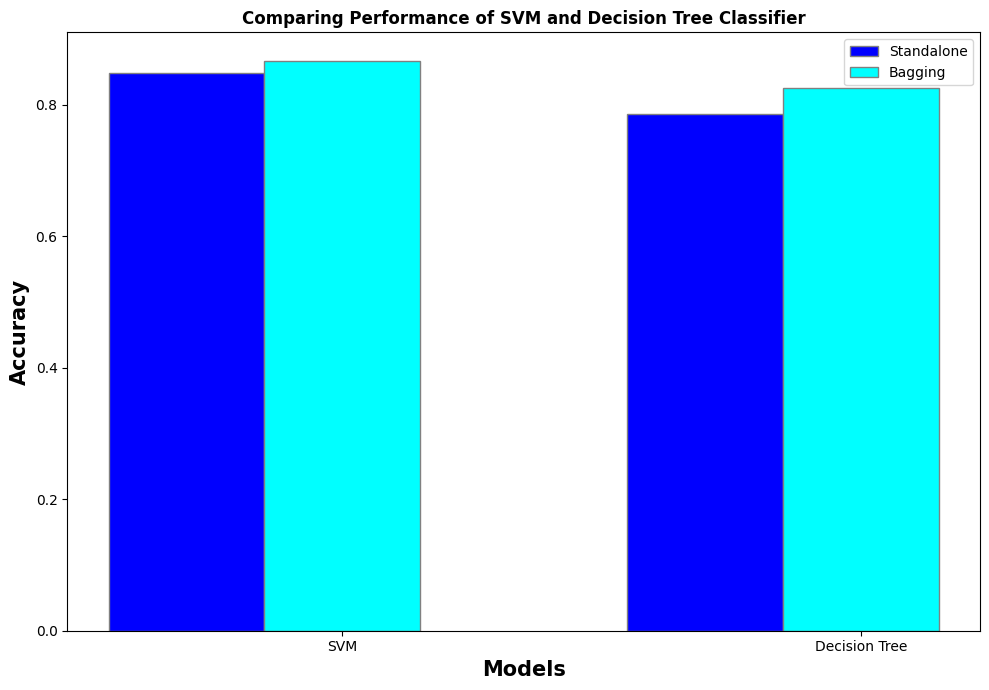

In [62]:
models = ['SVM', 'Decision Tree']
standalone_accuracies = [svm_accuracy, dt_accuracy]
bagging_accuracies = [bagging_svm_accuracy, bagging_dt_accuracy]

barWidth = 0.3
r1 = range(len(standalone_accuracies))
r2 = [x + barWidth for x in r1]

plt.figure(figsize=(10, 7))
plt.bar(r1, standalone_accuracies, width=barWidth, color='blue', edgecolor='grey', label='Standalone')
plt.bar(r2, bagging_accuracies, width=barWidth, color='cyan', edgecolor='grey', label='Bagging')

plt.xlabel('Models', fontweight='bold', fontsize=15)
plt.ylabel('Accuracy', fontweight='bold', fontsize=15)
plt.xticks([r + barWidth for r in range(len(standalone_accuracies))], models)
plt.title('Comparing Performance of SVM and Decision Tree Classifier', fontweight='bold')
plt.legend()

plt.tight_layout()
plt.show()

Here's the comparison between SVM and Decision Tree classifiers:

From the graph:

1. **SVM**: The Bagging approach offers a modest improvement over the standalone SVM.
2. **Decision Tree**: Bagging provides a more significant performance boost compared to its standalone counterpart.

**Observations**:
- **Bagging with SVM**: The improvement is marginal. SVM inherently tries to maximize the margin between classes, which can already make it relatively robust to noise or minor variations in data.
  
- **Bagging with Decision Trees**: The improvement is more pronounced. Decision Trees, being high-variance models, can overfit to their training data. Bagging, which involves creating multiple trees on different subsets of data and averaging out their predictions, reduces this variance and overfitting, leading to better performance.

**Conclusion**:
While Bagging enhances the performance for both models, it's particularly beneficial for high-variance models like Decision Trees. If computational resources allow, it makes sense to use Bagging, especially with algorithms that tend to overfit or show high sensitivity to training data.